In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resume-dataset/resume_data.csv


In [24]:
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm  
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import RandomOverSampler

In [25]:
df = pd.read_csv("/kaggle/input/resume-dataset/resume_data.csv", encoding="ISO-8859-1")

df.describe()



,matched_score
count,9544.000000
mean,0.660831
std,0.167040
min,0.000000
25%,0.583333
50%,0.683333
75%,0.793333
max,0.970000


In [26]:
df.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,online_links,issue_dates,expiry_dates,ï»¿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name Ã¯Â¼ City , State', 'Company Na...",...,NaN,NaN,NaN,Business Development Executive,Bachelor/Honors,1 to 3 years,Age 22 to 30 years,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000
4,NaN,Professional accountant with an outstanding wo...,"['Analytical reasoning', 'Compliance testing k...",['Kent State University'],['Bachelor of Business Administration'],[None],['3.84'],[None],['Accounting'],"['Company Name', 'Company Name', 'Company Name...",...,[None],[None],"['February 15, 2021']",Senior iOS Engineer,Bachelor of Science (BSc) in Computer Science,At least 4 years,NaN,iOS Lifecycle\nRequirement Analysis\nNative Fr...,iOS\niOS App Developer\niOS Application Develo...,0.650000


In [27]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [28]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [29]:
df["resume_text"] = df["career_objective"].fillna("") + " " + df["skills"].fillna("") + " " + df["degree_names"].fillna("")
df["resume_text"] = df["resume_text"].apply(preprocess_text)
df["job_text"] = df["educationaL_requirements"].fillna("") + " " + df["skills_required"].fillna("")
df["job_text"] = df["job_text"].apply(preprocess_text)

In [30]:
df = df.reset_index(drop=True)

In [31]:

def encode_text(text_list, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Encoding..."):
        batch = text_list[i:i+batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=True)
        embeddings.append(batch_embeddings.cpu())  # Move to CPU to save memory
    return torch.cat(embeddings, dim=0)

In [32]:
resume_embeddings = encode_text(df["resume_text"].tolist())
job_embeddings = encode_text(df["job_text"].tolist())

Encoding...:   0%|          | 0/299 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   1%|          | 2/299 [00:00<00:17, 17.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   2%|▏         | 5/299 [00:00<00:14, 20.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   3%|▎         | 8/299 [00:00<00:16, 17.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   3%|▎         | 10/299 [00:00<00:16, 17.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   4%|▍         | 12/299 [00:00<00:16, 17.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   5%|▍         | 14/299 [00:00<00:16, 17.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   5%|▌         | 16/299 [00:00<00:16, 17.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   6%|▌         | 18/299 [00:01<00:16, 17.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   7%|▋         | 20/299 [00:01<00:15, 17.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   7%|▋         | 22/299 [00:01<00:15, 17.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   8%|▊         | 24/299 [00:01<00:15, 18.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   9%|▊         | 26/299 [00:01<00:15, 18.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   9%|▉         | 28/299 [00:01<00:15, 17.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  10%|█         | 30/299 [00:01<00:14, 18.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  11%|█         | 32/299 [00:01<00:14, 18.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  12%|█▏        | 35/299 [00:01<00:13, 19.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  12%|█▏        | 37/299 [00:02<00:13, 19.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  13%|█▎        | 39/299 [00:02<00:14, 18.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  14%|█▎        | 41/299 [00:02<00:14, 17.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  14%|█▍        | 43/299 [00:02<00:14, 17.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  15%|█▌        | 45/299 [00:02<00:14, 17.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  16%|█▌        | 47/299 [00:02<00:14, 17.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  17%|█▋        | 50/299 [00:02<00:13, 17.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  17%|█▋        | 52/299 [00:02<00:13, 18.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  18%|█▊        | 55/299 [00:03<00:12, 18.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  19%|█▉        | 57/299 [00:03<00:13, 18.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  20%|█▉        | 59/299 [00:03<00:13, 18.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  20%|██        | 61/299 [00:03<00:13, 17.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  21%|██▏       | 64/299 [00:03<00:12, 18.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  22%|██▏       | 66/299 [00:03<00:12, 18.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  23%|██▎       | 68/299 [00:03<00:12, 18.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  23%|██▎       | 70/299 [00:03<00:12, 18.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  24%|██▍       | 72/299 [00:03<00:12, 17.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  25%|██▌       | 75/299 [00:04<00:11, 19.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  26%|██▌       | 77/299 [00:04<00:12, 18.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  27%|██▋       | 80/299 [00:04<00:11, 19.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  27%|██▋       | 82/299 [00:04<00:11, 18.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  28%|██▊       | 84/299 [00:04<00:11, 18.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  29%|██▉       | 86/299 [00:04<00:11, 18.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  30%|██▉       | 89/299 [00:04<00:10, 19.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  30%|███       | 91/299 [00:04<00:10, 19.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  31%|███       | 93/299 [00:05<00:11, 18.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  32%|███▏      | 95/299 [00:05<00:12, 16.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  32%|███▏      | 97/299 [00:05<00:12, 16.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  33%|███▎      | 99/299 [00:05<00:11, 16.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  34%|███▍      | 102/299 [00:05<00:11, 17.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  35%|███▍      | 104/299 [00:05<00:10, 17.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  35%|███▌      | 106/299 [00:05<00:11, 17.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  36%|███▌      | 108/299 [00:05<00:10, 18.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  37%|███▋      | 110/299 [00:06<00:10, 17.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  37%|███▋      | 112/299 [00:06<00:10, 17.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  38%|███▊      | 114/299 [00:06<00:11, 16.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  39%|███▉      | 116/299 [00:06<00:10, 17.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  39%|███▉      | 118/299 [00:06<00:10, 17.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  40%|████      | 121/299 [00:06<00:09, 18.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  41%|████      | 123/299 [00:06<00:09, 18.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  42%|████▏     | 125/299 [00:06<00:09, 17.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  42%|████▏     | 127/299 [00:07<00:09, 17.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  43%|████▎     | 129/299 [00:07<00:09, 17.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  44%|████▍     | 131/299 [00:07<00:09, 18.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  44%|████▍     | 133/299 [00:07<00:08, 18.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  45%|████▌     | 135/299 [00:07<00:09, 17.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  46%|████▌     | 137/299 [00:07<00:09, 17.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  46%|████▋     | 139/299 [00:07<00:09, 16.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  47%|████▋     | 141/299 [00:07<00:09, 16.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  48%|████▊     | 143/299 [00:08<00:09, 16.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  48%|████▊     | 145/299 [00:08<00:19,  8.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  49%|████▉     | 147/299 [00:08<00:16,  9.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  50%|████▉     | 149/299 [00:08<00:13, 11.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  51%|█████     | 151/299 [00:08<00:12, 12.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  51%|█████     | 153/299 [00:09<00:10, 13.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  52%|█████▏    | 155/299 [00:09<00:09, 15.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  53%|█████▎    | 157/299 [00:09<00:09, 15.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  53%|█████▎    | 159/299 [00:09<00:08, 16.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  54%|█████▍    | 161/299 [00:09<00:08, 16.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  55%|█████▍    | 163/299 [00:09<00:08, 16.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  55%|█████▌    | 165/299 [00:09<00:08, 16.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  56%|█████▌    | 167/299 [00:09<00:07, 17.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  57%|█████▋    | 169/299 [00:09<00:07, 16.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  57%|█████▋    | 171/299 [00:10<00:07, 17.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  58%|█████▊    | 173/299 [00:10<00:07, 17.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  59%|█████▊    | 175/299 [00:10<00:07, 17.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  59%|█████▉    | 177/299 [00:10<00:06, 17.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  60%|██████    | 180/299 [00:10<00:06, 18.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  61%|██████    | 182/299 [00:10<00:06, 18.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  62%|██████▏   | 185/299 [00:10<00:05, 20.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  63%|██████▎   | 188/299 [00:10<00:05, 20.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  64%|██████▍   | 191/299 [00:11<00:05, 18.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  65%|██████▍   | 193/299 [00:11<00:05, 18.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  66%|██████▌   | 196/299 [00:11<00:05, 19.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  67%|██████▋   | 199/299 [00:11<00:05, 19.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  67%|██████▋   | 201/299 [00:11<00:05, 19.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  68%|██████▊   | 203/299 [00:11<00:05, 18.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  69%|██████▉   | 206/299 [00:11<00:05, 18.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  70%|██████▉   | 208/299 [00:11<00:04, 18.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  71%|███████   | 211/299 [00:12<00:04, 19.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  71%|███████   | 213/299 [00:12<00:04, 19.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  72%|███████▏  | 215/299 [00:12<00:04, 18.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  73%|███████▎  | 217/299 [00:12<00:04, 18.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  73%|███████▎  | 219/299 [00:12<00:04, 18.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  74%|███████▍  | 222/299 [00:12<00:03, 19.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  75%|███████▍  | 224/299 [00:12<00:03, 19.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  76%|███████▌  | 226/299 [00:12<00:03, 19.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  76%|███████▋  | 228/299 [00:13<00:03, 19.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  77%|███████▋  | 230/299 [00:13<00:03, 18.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  78%|███████▊  | 232/299 [00:13<00:03, 18.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  78%|███████▊  | 234/299 [00:13<00:03, 17.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  79%|███████▉  | 236/299 [00:13<00:03, 17.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  80%|███████▉  | 238/299 [00:13<00:03, 16.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  80%|████████  | 240/299 [00:13<00:03, 17.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  81%|████████  | 242/299 [00:13<00:03, 17.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  82%|████████▏ | 244/299 [00:13<00:03, 17.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  82%|████████▏ | 246/299 [00:14<00:03, 17.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  83%|████████▎ | 249/299 [00:14<00:02, 19.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  84%|████████▍ | 251/299 [00:14<00:02, 18.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  85%|████████▍ | 253/299 [00:14<00:02, 18.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  86%|████████▌ | 256/299 [00:14<00:02, 18.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  86%|████████▋ | 258/299 [00:14<00:02, 18.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  87%|████████▋ | 260/299 [00:14<00:02, 18.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  88%|████████▊ | 262/299 [00:14<00:02, 17.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  88%|████████▊ | 264/299 [00:15<00:02, 17.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  89%|████████▉ | 266/299 [00:15<00:01, 17.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  90%|████████▉ | 268/299 [00:15<00:01, 17.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  90%|█████████ | 270/299 [00:15<00:01, 17.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  91%|█████████ | 272/299 [00:15<00:01, 17.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  92%|█████████▏| 274/299 [00:15<00:01, 17.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  92%|█████████▏| 276/299 [00:15<00:01, 18.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  93%|█████████▎| 279/299 [00:15<00:01, 18.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  94%|█████████▍| 281/299 [00:15<00:00, 18.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  95%|█████████▍| 283/299 [00:16<00:00, 18.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  95%|█████████▌| 285/299 [00:16<00:00, 17.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  96%|█████████▌| 287/299 [00:16<00:00, 18.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  97%|█████████▋| 290/299 [00:16<00:00, 19.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  98%|█████████▊| 293/299 [00:16<00:00, 20.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  99%|█████████▉| 296/299 [00:16<00:00, 18.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   0%|          | 0/299 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   1%|▏         | 4/299 [00:00<00:08, 35.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   3%|▎         | 8/299 [00:00<00:08, 36.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   4%|▍         | 12/299 [00:00<00:07, 36.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   5%|▌         | 16/299 [00:00<00:07, 35.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   7%|▋         | 20/299 [00:00<00:07, 36.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   8%|▊         | 24/299 [00:00<00:07, 37.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:   9%|▉         | 28/299 [00:00<00:07, 37.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  11%|█         | 32/299 [00:00<00:07, 37.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  12%|█▏        | 36/299 [00:00<00:07, 37.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  13%|█▎        | 40/299 [00:01<00:06, 37.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  15%|█▍        | 44/299 [00:01<00:06, 36.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  16%|█▌        | 48/299 [00:01<00:06, 37.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  17%|█▋        | 52/299 [00:01<00:06, 37.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  19%|█▊        | 56/299 [00:01<00:06, 37.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  20%|██        | 60/299 [00:01<00:06, 37.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  21%|██▏       | 64/299 [00:01<00:06, 37.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  23%|██▎       | 68/299 [00:01<00:06, 37.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  24%|██▍       | 72/299 [00:01<00:05, 37.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  25%|██▌       | 76/299 [00:02<00:05, 37.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  27%|██▋       | 80/299 [00:02<00:05, 37.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  28%|██▊       | 84/299 [00:02<00:05, 37.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  29%|██▉       | 88/299 [00:02<00:05, 37.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  31%|███       | 92/299 [00:02<00:05, 37.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  32%|███▏      | 96/299 [00:02<00:05, 37.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  33%|███▎      | 100/299 [00:02<00:05, 37.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  35%|███▍      | 104/299 [00:02<00:05, 37.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  36%|███▌      | 108/299 [00:02<00:05, 36.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  37%|███▋      | 112/299 [00:03<00:05, 36.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  39%|███▉      | 116/299 [00:03<00:04, 37.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  40%|████      | 120/299 [00:03<00:04, 37.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  41%|████▏     | 124/299 [00:03<00:04, 36.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  43%|████▎     | 128/299 [00:03<00:04, 36.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  44%|████▍     | 132/299 [00:03<00:04, 37.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  45%|████▌     | 136/299 [00:03<00:04, 37.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  47%|████▋     | 140/299 [00:03<00:04, 36.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  48%|████▊     | 144/299 [00:03<00:04, 37.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  49%|████▉     | 148/299 [00:03<00:04, 37.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  51%|█████     | 152/299 [00:04<00:03, 37.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  52%|█████▏    | 156/299 [00:04<00:03, 38.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  54%|█████▎    | 160/299 [00:04<00:03, 37.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  55%|█████▍    | 164/299 [00:04<00:03, 37.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  56%|█████▌    | 168/299 [00:04<00:03, 37.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  58%|█████▊    | 172/299 [00:04<00:03, 38.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  59%|█████▉    | 176/299 [00:04<00:03, 38.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  60%|██████    | 180/299 [00:04<00:03, 37.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  62%|██████▏   | 184/299 [00:04<00:03, 37.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  63%|██████▎   | 188/299 [00:05<00:02, 37.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  64%|██████▍   | 192/299 [00:05<00:02, 37.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  66%|██████▌   | 196/299 [00:05<00:02, 37.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  67%|██████▋   | 200/299 [00:05<00:02, 37.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  68%|██████▊   | 204/299 [00:05<00:02, 37.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  70%|██████▉   | 208/299 [00:05<00:02, 36.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  71%|███████   | 212/299 [00:05<00:02, 37.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  72%|███████▏  | 216/299 [00:05<00:02, 37.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  74%|███████▎  | 220/299 [00:05<00:02, 37.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  75%|███████▍  | 224/299 [00:06<00:01, 37.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  76%|███████▋  | 228/299 [00:06<00:01, 37.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  78%|███████▊  | 232/299 [00:06<00:01, 37.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  79%|███████▉  | 236/299 [00:06<00:01, 37.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  80%|████████  | 240/299 [00:06<00:01, 37.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  82%|████████▏ | 244/299 [00:06<00:01, 37.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  83%|████████▎ | 248/299 [00:06<00:01, 37.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  84%|████████▍ | 252/299 [00:06<00:01, 37.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  86%|████████▌ | 256/299 [00:06<00:01, 37.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  87%|████████▋ | 260/299 [00:06<00:01, 37.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  88%|████████▊ | 264/299 [00:07<00:00, 37.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  90%|████████▉ | 268/299 [00:07<00:00, 37.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  91%|█████████ | 272/299 [00:07<00:00, 37.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  92%|█████████▏| 276/299 [00:07<00:00, 37.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  94%|█████████▎| 280/299 [00:07<00:00, 37.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  95%|█████████▍| 284/299 [00:07<00:00, 37.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  96%|█████████▋| 288/299 [00:07<00:00, 37.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  98%|█████████▊| 292/299 [00:07<00:00, 37.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...:  99%|█████████▉| 296/299 [00:07<00:00, 37.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding...: 100%|██████████| 299/299 [00:08<00:00, 37.32it/s]


In [33]:
df["match_score"] = [
    cosine_similarity([resume_embeddings[i].numpy()], [job_embeddings[i].numpy()])[0][0] 
    for i in range(len(df))
]

df["match_label"] = df["match_score"].apply(
    lambda x: "Exceptional Match!" if x >= 0.85 else 
              "Strong Match!" if x >= 0.7 else 
              "Moderate Match!" if x >= 0.55 else 
              "Weak Match!" if x >= 0.4 else 
              "Poor Match!"
)

df["match_label_num"] = df["match_label"].map({
    "Exceptional Match!": 4,
    "Strong Match!": 3,
    "Moderate Match!": 2,
    "Weak Match!": 1,
    "Poor Match!": 0
})


Class Distribution before Oversampling:
 match_label
Poor Match!        8360
Weak Match!        1112
Moderate Match!      72
Name: count, dtype: int64


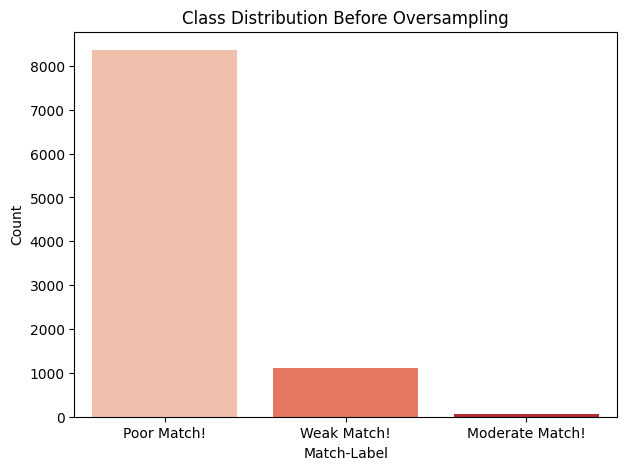

In [34]:
class_counts = df["match_label"].value_counts()
print("Class Distribution before Oversampling:\n", class_counts)


plt.figure(figsize=(7, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Reds")
plt.xlabel("Match-Label")
plt.ylabel("Count")
plt.title("Class Distribution Before Oversampling")
plt.show()

Class Counts Before SMOTE:
 match_label_num
0    6698
1     884
2      53
Name: count, dtype: int64
Class Distribution After SMOTE:
 match_label
Poor Match!        6698
Moderate Match!    6698
Weak Match!        6698
Name: count, dtype: int64


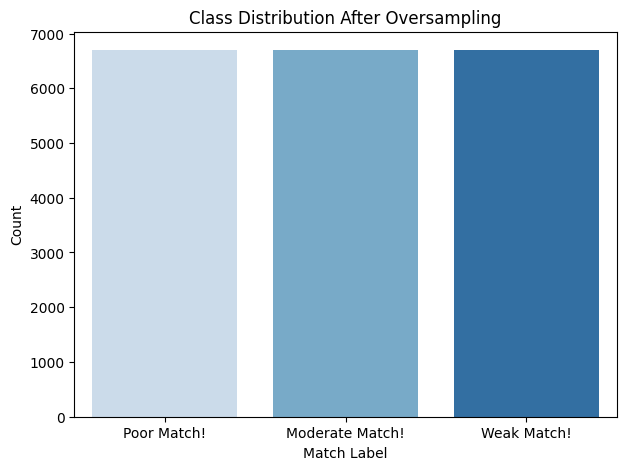

In [35]:


if "match_label_num" not in df.columns:
    raise ValueError("Column 'match_label_num' is missing from dataframe!")

X_train, X_test, y_train, y_test = train_test_split(
    df[["match_score"]], df["match_label_num"], test_size=0.2, random_state=42
)

class_counts = y_train.value_counts()
print("Class Counts Before SMOTE:\n", class_counts)


for label in class_counts.index:
    if class_counts[label] < 2:
        duplicate = X_train[y_train == label]
        X_train = pd.concat([X_train, duplicate], axis=0)
        y_train = pd.concat([y_train, pd.Series([label] * len(duplicate), index=duplicate.index)], axis=0)


class_counts = y_train.value_counts()
if class_counts.min() > 1:
    smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=min(1, len(X_train) - 1))
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    df_resampled = pd.DataFrame(X_train_resampled, columns=["match_score"])
    df_resampled["match_label_num"] = y_train_resampled
    df_resampled["match_label"] = df_resampled["match_label_num"].map({
        0: "Poor Match!",
        1: "Weak Match!",
        2: "Moderate Match!",
        3: "Strong Match!",
        4: "Exceptional Match!"
    })
    
    df_resampled["resume_text"] = df.sample(n=len(df_resampled), replace=True)["resume_text"].values
    df_resampled["job_text"] = df.sample(n=len(df_resampled), replace=True)["job_text"].values

    print("Class Distribution After SMOTE:\n", df_resampled["match_label"].value_counts())

    plt.figure(figsize=(7, 5))
    sns.barplot(x=df_resampled["match_label"].value_counts().index, 
                y=df_resampled["match_label"].value_counts().values, palette="Blues")
    plt.xlabel("Match Label")
    plt.ylabel("Count")
    plt.title("Class Distribution After Oversampling")
    plt.show()
else:
    print("No oversampling needed.")


In [36]:
print(classification_report(df_resampled["match_label"], df_resampled["match_label"]))

                 precision    recall  f1-score   support

Moderate Match!       1.00      1.00      1.00      6698
    Poor Match!       1.00      1.00      1.00      6698
    Weak Match!       1.00      1.00      1.00      6698

       accuracy                           1.00     20094
      macro avg       1.00      1.00      1.00     20094
   weighted avg       1.00      1.00      1.00     20094



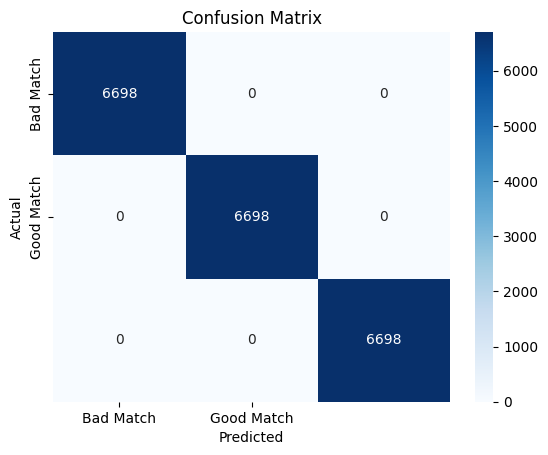

In [37]:
cm = confusion_matrix(df_resampled["match_label"], df_resampled["match_label"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad Match", "Good Match"], yticklabels=["Bad Match", "Good Match"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [38]:
top_matches = df_resampled.sort_values(by="match_score", ascending=False)[["resume_text", "job_text", "match_score", "match_label"]].head(10)
top_matches.to_csv("/kaggle/working/top_matched_resumes.csv", index=False)
print(top_matches)

                                             resume_text  \
165     business strategy consulting excel capital ma...   
18315   microsoft office word excel power point outlo...   
15012  fresher with excellent communication good anal...   
17666   proengineercreo minitab ms office suite ms pr...   
15353   budget hardware network systems database dec ...   
18478  to pursue excellence in the dynamic business w...   
16533  a challenging position in a manufacturing engi...   
13901   assembly atm cadence calibration ca hardware ...   
17659  leadership and team building oriented mentalit...   
15712  fresher looking to join as a data analyst and ...   

                                                job_text  match_score  \
165    master of business administration mba brand pr...     0.677711   
18315          bba in accounting and finance vat and tax     0.677470   
15012  bsc in civil engineering from a reputed univer...     0.676693   
17666          bba in accounting and finance va

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


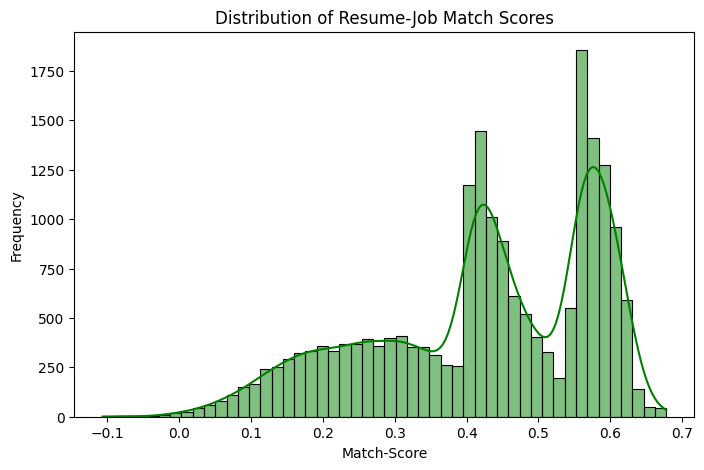

In [39]:
plt.figure(figsize=(8, 5))
sns.histplot(df_resampled["match_score"], bins=50, kde=True, color="green")

plt.xlabel("Match-Score")
plt.ylabel("Frequency")
plt.title("Distribution of Resume-Job Match Scores")
plt.show()

In [40]:
def predict_match(resume, job):
    

    resume = preprocess_text(resume)
    job = preprocess_text(job)

    resume_emb = model.encode([resume], convert_to_tensor=True).cpu().numpy()
    job_emb = model.encode([job], convert_to_tensor=True).cpu().numpy()

    score = cosine_similarity(resume_emb, job_emb)[0][0]


    if score >= 0.85:
        label = "Exceptional Match!"
    elif score >= 0.7:
        label = "Strong Match!"
    elif score >= 0.55:
        label = "Moderate Match!"
    elif score >= 0.4:
        label = "Weak Match!"
    else:
        label = "Poor Match!"

    return score, label


In [41]:
inputs = [
    ("Software engineer with 4 years of experience in Java, Spring Boot, and microservices.",
     "Seeking a backend developer role requiring expertise in Java, Spring Boot, and cloud computing."),

    ("Entry-level data analyst with knowledge of SQL, Excel, and basic Python.",
     "Looking for a data analyst position where I can apply my skills in SQL, Python, and Tableau."),

    ("Mechanical engineer with experience in automotive design and CAD modeling.",
     "Seeking a software development role leveraging my experience in Java, Spring Boot, and cloud computing."),

    ("Experienced chef skilled in Italian cuisine and pastry making.",
     "Looking for opportunities to transition into blockchain development with expertise in Solidity and smart contracts."),

    ("AI engineer with Python, TensorFlow, and some knowledge of cloud computing.",
     "Seeking a cloud engineering role where I can apply my knowledge of AWS, Docker, and basic ML concepts."),  

    ("Hardworking professional, good communication skills, and team player.",
     "Looking for an ML engineering position focused on TensorFlow, NLP, and cloud deployment."), 

    ("Expert in Python, machine learning, deep learning, and AI research.",
     "Looking for a senior data scientist role that involves AI, ML, Python, and research-driven projects.") 
]



for i, (resume_input, job_input) in enumerate(inputs):
    match_score, match_label = predict_match(resume_input, job_input)  
    print(f"Example {i+1}:")
    print(f"Resume: {resume_input}")
    print(f"Job: {job_input}")
    print(f"Match Score: {match_score:.4f}")
    print(f"Classification: {match_label}\n")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Example 1:
Resume: Software engineer with 4 years of experience in Java, Spring Boot, and microservices.
Job: Seeking a backend developer role requiring expertise in Java, Spring Boot, and cloud computing.
Match Score: 0.6803
Classification: Moderate Match!



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Example 2:
Resume: Entry-level data analyst with knowledge of SQL, Excel, and basic Python.
Job: Looking for a data analyst position where I can apply my skills in SQL, Python, and Tableau.
Match Score: 0.7143
Classification: Strong Match!



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Example 3:
Resume: Mechanical engineer with experience in automotive design and CAD modeling.
Job: Seeking a software development role leveraging my experience in Java, Spring Boot, and cloud computing.
Match Score: 0.1822
Classification: Poor Match!



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Example 4:
Resume: Experienced chef skilled in Italian cuisine and pastry making.
Job: Looking for opportunities to transition into blockchain development with expertise in Solidity and smart contracts.
Match Score: 0.2878
Classification: Poor Match!



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Example 5:
Resume: AI engineer with Python, TensorFlow, and some knowledge of cloud computing.
Job: Seeking a cloud engineering role where I can apply my knowledge of AWS, Docker, and basic ML concepts.
Match Score: 0.5698
Classification: Moderate Match!



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Example 6:
Resume: Hardworking professional, good communication skills, and team player.
Job: Looking for an ML engineering position focused on TensorFlow, NLP, and cloud deployment.
Match Score: 0.1568
Classification: Poor Match!



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Example 7:
Resume: Expert in Python, machine learning, deep learning, and AI research.
Job: Looking for a senior data scientist role that involves AI, ML, Python, and research-driven projects.
Match Score: 0.6294
Classification: Moderate Match!

